### MNIST 데이터 셋 파악
#### 전체 데이터 샘플 수
- Training set : 60000 samples
- Test set : 10000 samples

#### 전처리하기 전 MNIST 로우 데이터 모양 확인
- raw_dataset[i] ->  raw_dataset의 샘플을 튜플 형태로 반환
- (28X28 사이즈 흑백 이미지, Label) 로 이루어진 튜플임

In [7]:
import torch # 기본 파이토치 기능
import torch.nn as nn # nn 모듈 기능
import torch.nn.functional as F # 기본 신경망 함수
import torch.optim as optim # 최적화
from torchvision import datasets, transforms # 데이터셋 처리
import matplotlib.pyplot as plt # 데이터 시각화

# ========================
# 1. 데이터 로드 및 전처리
# ========================
def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # 평균 0.5, 표준편차 0.5로 정규화
    ])
    # 학습 데이터 셋 다운로드 60000개 / 저장 위치는 root의 data 폴더 
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    # 테스트 데이터 셋 다운로드 10000개 / 저장 위치는 root의 data 폴더 
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    
    # 6만개 샘플들을 64 배치 사이즈 설정 및 셔플 설정하여 랜덤하게 train_loader에 담는다. 
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    # 1만개 샘플들을 64 배치 사이즈 설정 및 셔플 미설정하여 순서대로 test_loader에 담는다. 
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

### 1. 데이터 로드 및 전처리를 위한 코드
- 배치 사이즈는 64개 (28x28 사이즈 텐서 64개가 차례대로 입력되어 64개가 쌓이면 64개의 텐서를 한번에 모델에서 처리하여 64개 분류 작업 실행)
- 해당 함수를 메인에서 불러서 64개 배치 사이즈로 설정한 60000개 샘플과 10000개 샘플을 train_loader와 test_loader에 담아 반환해준다. 

#### _loader 객체 
- torch.utils.data.DataLoader는 Batch단위로 데이터가 적재됨. 그래서 Batch size 설정이 필요함

In [8]:
# ========================
# 2. 모델 정의
# ========================
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # super(CNN,self)는 부모 클래스 nn.module의 INIT 메서드를 호출하여 제대로 상속받도록 한다.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1채널 28x28 (1x28x28) -> 32채널 28x28 (32x28x28)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32채널 28x28 (32x28x28) -> 64채널 28x28 (32x28x28)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 64x28x28 -> 64x14x14
        
        # Fully Connected Layers
        # self.fc1 = None  # Input size will be dynamically calculated
        self.fc1 = nn.Linear(12544, 128) # 동적으로 초기화하던 fc1을 정적 초기화하도록 수정
        self.fc2 = nn.Linear(128, 10)  # Output layer: 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))  # Apply Conv2D and MaxPooling
        x = x.view(x.size(0), -1)  # Flatten tensor to 2D

        # Dynamically initialize fc1 based on input size
        #if self.fc1 is None:
        #    self.fc1 = nn.Linear(x.size(1), 128).to(x.device)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### __init__ ()
#### super(CNN, self).__init__()을 해야하는 이유
- super(LeNet5, self).__init__()는 부모 클래스인 nn.Module의 초기화 메서드를 호출하여 LeNet5 클래스가 PyTorch의 모델 클래스 기능을 제대로 상속받고 사용할 수 있도록 보장
- 특히 nn.Module은 학습 가능한 파라미터 관리, 계층 추적 등의 핵심 기능을 제공하므로, 이를 호출하지 않으면 모델이 제대로 작동하지 않음
#### 모델의 구조(레이어)를 정의하거나 속성을 초기화하는 데 사용. 객체가 생성될 때 실행.
- conv1 layer : 1채널에서 32채널로, 커널 사이즈 3x3, 패딩 = 1 (이미지 사이즈 유지됨) 32x28x28 
- conv2 layer : 32채널에서 64채널로, 커널 사이즈 3x3, 패딩 = 1 (이미지 사이즈 유지됨) 64x28x28
- pooling layer : 2x2 크기 Max pooling !! 
- fully connected layer 1 : 가변적 크기 
- fully connected layer 2 : 레이어 입력 크기 1x128 크기, 레이어 출력 크기 1x10 (최종 10class 분류)

### forward ()
#### 데이터가 모델을 통과하는 동안 실행되는 메서드. 레이어 간의 연결 방식을 정의.
- __init__ () 단계에서 정적 초기화되는 레이어들 conv1, conv2, pool, fc2
- fc1은 forward () 단계에서 초기화하므로 동적 초기화임
- x.view에서 x.size(0) 는 x의 0번째 차원 사이즈. 즉, 배치 사이즈를 의미 (64x64x28x28에서 pooling했으므로 64x64x14x14 차원이 됨)
- 64x64x28x28 -> 배치 사이즈 x 채널 사이즈 x 픽셀 사이즈 x 픽셀 사이즈


### 코드 진행 순서
#### 정적 초기화
1) __init__ 메서드에서 정적으로 레이어를 초기화.
2) 초기화된 레이어의 파라미터는 기본적으로 CPU에 생성.
3) model.to(device) 호출 시, 모델 전체가 지정된 장치(CPU 또는 GPU)로 이동. -> **이 시점에는 fc1레이어는 존재하지 않았음**
#### 동적 초기화
1) forward 실행 중 필요 시 레이어를 동적으로 초기화. -> **이때 fc1이 동적 초기화를 통해 생성되었음**
2) 이때, to(x.device)에 의해 데이터가 위치한 장치로 바로 이동.


### fc1의 동적 초기화
- fc1이 굳이 동적 초기화해야하는 이유는? MNIST 데이터셋은 고정된 사이즈의 이미지만 처리하고 있음. fc1의 인풋 사이즈는 달라지지 않음. 그럼 정적 초기화 해도 되지 않는지?
- 정적 초기화하도록 수정하면 학습 및 결과가 달라지는지 확인 필요

In [9]:
# ========================
# 3. 학습 함수
# ========================
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device) 
    # 모델의 (정적 초기화 레이어의 파라미터 및 버퍼) cpu 디바이스로 보내짐 (근데 원래 cpu에서 생성되었음)
    # 모델이 원래 cpu에서 생성되었으므로, 사실 위치를 변경하지 않으나, 코드의 일관성, 호환성, 안정성, 명확성을 위하여 코드로 명시하는 것이 좋음
    # 추후 GPU에서 학습 시 모델을 GPU로 보내기 위해 값을 변경해주어야 함 

    for epoch in range(num_epochs):
        model.train() # 모델을 training mode로 전환
        total_loss = 0 # loss 값 초기화 
        for images, labels in train_loader: # 훈련 셋의 배치 단위로 images, lables 반환이 반복됨 
            images, labels = images.to(device), labels.to(device) # 데이터x도 cpu 디바이스로 보냄. (마찬가지로 GPU로 변경 시 GPU로 보내짐)

            # Forward pass
            outputs = model(images) # images만 모델에 입력
            loss = criterion(outputs, labels) # 모델 출력 결과와 정답 비교하여 loss 계산 

            # Backward pass and optimization
            optimizer.zero_grad() # 옵티마이저의 기울기 초기화 
            loss.backward() # 손실에 대한 기울기 계산 
            optimizer.step() # 옵티마이저의 최적화 단계 수행

            total_loss += loss.item() # 손실 누적 값 계산 
        
        # 한 Epoch에서의 평균 손실 출력
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

### 모델을 학습시키는 함수
#### Args (arguments)
- model (nn.Module): 학습할 모델
- train_loader (DataLoader): 학습 데이터 로더
- criterion (Loss): 손실 함수
- optimizer (Optimizer): 최적화 알고리즘
- num_epochs (int): 학습할 에포크 수

In [10]:
# ========================
# 4. 평가 함수
# ========================
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # output = 64 x 10 (배치 사이즈 x 10차원 행벡터)
            _, predicted = torch.max(outputs, 1) # torch.max의 반환 값은 튜플 : 각 행의 최대값, 각 행의 최대값 인덱스
            total += labels.size(0) # 현재 샘플 갯수 (배치 단위로 더함 64+64+ ... )
            correct += (predicted == labels).sum().item() # (predicted == labels)는 Boolean 값이고, 이것 또한 batch size 단위로 계산됨. 즉 64 차원의 Boolean값이 저장된 텐서임

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')

### 평가 단계
- with 구문 : 컨텍스트 매니저를 사용하는 구문
- torch.no_grad()는 PyTorch의 컨텍스트 매니저로, 블록 내에서 **자동 미분(gradient 계산)**을 비활성화함
- _, predicted = torch.max(outputs, 1) : output은 64x10의 텐서. (배치 사이즈 x 행벡터 차원)
**예시**
output은 10개의 행벡터(각 데이터 마다의 예측값)이 64배치사이즈로 결합되어 있음
[[x, x, x, x, x, max, x, x, x, x], : 예측값1
 [x, x, x, x, x, x, x, max, x, x], : 예측값2
 ...
 [x, x, x, x, x, x, x, x, x, max], : 예측값63
 [x, x, max, x, x, x, x, x, x, x]] : 예측값64

- labels는 torchvision으로부터 dataset을 불러올 때 **배열** 형태로 불러와지고, torch.utils.data.DataLoader에 의하여 64 배치 사이즈 단위가 생김
- 배열의 차원은 1개 즉 labels.size(0) = 64

#### total 변수 누적 과정
| **Iteration**    | **labels.size(0)**      | **Total**      |
|-------------------|-------------------------|----------------|
| 1                | 64                      | 64             |
| 2                | 64                      | 128            |
| 3                | 64                      | 192            |
| ...              | ...                     | ...            |
| 마지막 배치       | 32 (잔여 샘플)          | 60000          |

#### .sum().item()
텐서의 합을 구하고 accuracy 계산을 위해 스칼라 값으로 변환

In [11]:
# ========================
# 5. 예측 시각화
# ========================
def visualize_predictions(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    data_iter = iter(test_loader) # test_loader를 iterator로 변환 (데이터를 직접 순회하기 위해)
    images, labels = next(data_iter) # 이터레이터를 생성하고 바로 next()를 호출하면 맨 처음 값부터 가져 옴
    images, labels = images[:5].to(device), labels[:5].to(device) # 처음부터 5까지 이미지랑 레이블을 디바이스로 보냄

    # 모델 예측
    outputs = model(images) # 모델에 이미지를 입력하고 아웃풋을 저장
    _, preds = torch.max(outputs, 1) # 예측값을 preds 변수에 저장 

    # 시각화
    fig, axes = plt.subplots(1, 5, figsize=(12, 3)) # 
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx].cpu().squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[idx].item()}\nPred: {preds[idx].item()}')
        ax.axis('off')
    plt.show()

### 시각화
#### plt.subplots ()
- Matplotlib를 사용하여 1행 5열의 서브플롯(각각의 작은 그래프)을 생성하고, 그래프의 전체 크기를 지정
* fig: 전체 그래프(figure)를 나타냄.
* axes: 서브플롯(개별 그래프)을 나타내는 객체(또는 배열).
* figsize: 전체 그래프의 크기(가로, 세로 크기).


#### images[idx].cpu().squeeze()
images[idx]: 배치에서 idx 번째 샘플 선택. 크기: [1, 28, 28].
.cpu(): 텐서를 GPU에서 CPU로 이동.
.squeeze(): 크기 1인 차원(채널 차원)을 제거. 최종 크기: [28, 28].


Epoch [1/5], Loss: 0.1395
Epoch [2/5], Loss: 0.0427
Epoch [3/5], Loss: 0.0241
Epoch [4/5], Loss: 0.0178
Epoch [5/5], Loss: 0.0115
Accuracy on test set: 98.76%


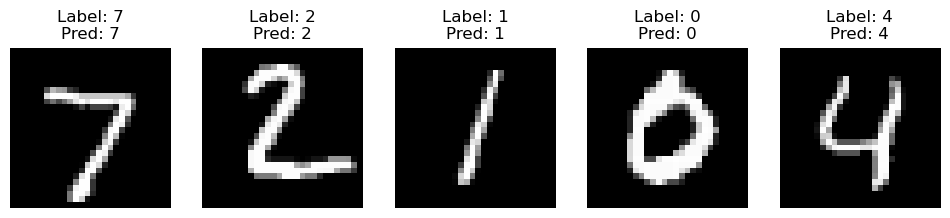

In [12]:
# ========================
# 6. 메인 실행
# ========================
if __name__ == "__main__":
    # 하이퍼파라미터
    batch_size = 64
    num_epochs = 5
    learning_rate = 0.001

    # 데이터 로드
    train_loader, test_loader = load_data(batch_size)

    # 모델 초기화
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 모델 학습
    train_model(model, train_loader, criterion, optimizer, num_epochs)

    # 모델 평가
    evaluate_model(model, test_loader)

    # 예측 시각화
    visualize_predictions(model, test_loader)